<a href="https://colab.research.google.com/github/kevinh2744/ArxivAnalysis/blob/main/Data_Cleaning_Centrality_Model_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 5450 Final Project
## Albi Domi, Kevin Hu, Rohan Rashid

## Imports

In [ ]:
import json
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from itertools import combinations
import networkx as nx

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
!!kaggle datasets download -d Cornell-University/arxiv

['Downloading arxiv.zip to /content',
 '',
 '  0% 0.00/1.10G [00:00<?, ?B/s]',
 '  1% 9.00M/1.10G [00:00<00:12, 92.0MB/s]',
 '  2% 21.0M/1.10G [00:00<00:10, 111MB/s] ',
 '  3% 32.0M/1.10G [00:00<00:11, 103MB/s]',
 '  4% 42.0M/1.10G [00:00<00:20, 55.7MB/s]',
 '  5% 52.0M/1.10G [00:00<00:17, 66.1MB/s]',
 '  6% 68.0M/1.10G [00:00<00:12, 89.4MB/s]',
 '  7% 79.0M/1.10G [00:01<00:14, 74.8MB/s]',
 '  8% 92.0M/1.10G [00:01<00:12, 88.2MB/s]',
 ' 10% 112M/1.10G [00:01<00:09, 113MB/s]  ',
 ' 11% 125M/1.10G [00:01<00:10, 104MB/s]',
 ' 12% 137M/1.10G [00:01<00:09, 108MB/s]',
 ' 13% 149M/1.10G [00:01<00:11, 92.5MB/s]',
 ' 14% 161M/1.10G [00:01<00:11, 90.2MB/s]',
 ' 16% 177M/1.10G [00:01<00:09, 106MB/s] ',
 ' 17% 189M/1.10G [00:02<00:09, 109MB/s]',
 ' 18% 201M/1.10G [00:02<00:14, 68.7MB/s]',
 ' 19% 210M/1.10G [00:02<00:13, 71.8MB/s]',
 ' 19% 219M/1.10G [00:02<00:12, 76.2MB/s]',
 ' 20% 228M/1.10G [00:02<00:13, 72.6MB/s]',
 ' 21% 243M/1.10G [00:02<00:10, 87.5MB/s]',
 ' 23% 265M/1.10G [00:03<00:07, 118M

In [ ]:
!unzip /content/arxiv.zip

Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


## Loading the Data

In [ ]:
filepath = '/content/arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(filepath, 'r') as f:
        for line in f:
            yield line

            
            
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    break

titles = []
abstracts = []
authors = []
categories = []
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    ref = paper_dict.get('journal-ref')
    try:
        year = int(ref[-4:]) 
        if 2000 < year < 2022:
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract'))
            authors.append(paper_dict.get('authors_parsed'))
            categories.append(paper_dict.get('categories'))
    except:
        pass 

arxiv_df = pd.DataFrame({
    'title': titles,
    'abstract': abstracts,
    'authors': authors,
    'categories': categories
})
arxiv_df.head()

,title,abstract,authors,categories
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",hep-ph
1,Polymer Quantum Mechanics and its Continuum Limit,A rather non-standard quantum representation...,"[[Corichi, Alejandro, ], [Vukasinac, Tatjana, ...",gr-qc
2,"The Spitzer c2d Survey of Large, Nearby, Inste...",We discuss the results from the combined IRA...,"[[Harvey, Paul, ], [Merin, Bruno, ], [Huard, T...",astro-ph
3,Fermionic superstring loop amplitudes in the p...,The pure spinor formulation of the ten-dimen...,"[[Stahn, Christian, ]]",hep-th
4,Lifetime of doubly charmed baryons,"In this work, we evaluate the lifetimes of t...","[[Chang, Chao-Hsi, ], [Li, Tong, ], [Li, Xue-Q...",hep-ph


## Data Cleaning
*Cleaning the authors:* transforming all author to the following schema: [Last Name] [First Initial].

*Cleaning the categories:* transforming all categories into their broader category: ['computer_science', 'economics', 'electrical_engineering_systems_science', 'math', 'physics', 'biology', 'finance', 'statistics']

<br>

Note: some authors in the dataset aren't people (e.g companies or institutions) and some author names also have affiliations attached to them (e.g. **FIND EXAMPLE**). These are not uniform, so we were unable to find an efficient way to clean these authors.

In [ ]:
def clean_author(l):
    # l contains last, first, middle name as values
    if len(l[1]) > 0:
        l[1] = l[1][0] + "."
    if len(l[2]) > 0:
        l[2] = l[2][0] + "."
    return re.sub(' +', ' ', " ".join(l).replace('\n', '').strip())

arxiv_df['authors_cleaned'] = arxiv_df['authors'].apply(lambda x: [clean_author(x[i]) for i in range(len(x))])

In [ ]:
def clean_label(label):
    cats = label.split(' ')
    cat_set = list()

    for x in cats:
        start = x[:2]
        if start == 'cs':
            cat_set.append('computer_science')
        elif start == 'ec':
            cat_set.append('economics')
        elif start == 'ee':
            cat_set.append('electrical_engineering_systems_science')
        elif start == 'ma':
            if x[4] == '.':
                cat_set.append('math')
            elif x[4] == '-':
                cat_set.append('physics')
        elif start in {'as', 'co', 'gr', 'he', 'nl', 'nu', 'ph', 'qu'}:
            cat_set.append('physics')
        elif start == 'q-':
            if x[2] == 'b':
                cat_set.append('biology')
            elif x[2] == 'f':
                cat_set.append('finance')
        elif start == 'st':
            cat_set.append('statistics')
    cat_str = cat_set[0]
    return cat_str

In [ ]:
arxiv_df['clean_categories'] = arxiv_df['categories'].apply(clean_label)

## Graphs and Centrality Analysis
For each category, the top authors were determined by a sum of two normalized scores: number of publications, and degree centrality. 

Number of publications was calculated through dataframe manipulation. Degree centrality was calculated by first generating a graph in which authors are nodes and an edge between two authors represents coauthorship (i.e. these authors have published a paper together), then calculating the number of incident edges for each node.

The scores were then z-score normalized and summed to calculate an overall score for each author. The top 10 authors for each category were then obtained by sorting by overall score.

In [ ]:
def get_df_by_cat(input_df, category):
    df = input_df[input_df['clean_categories'].str.contains(category)]
    return df

def gen_network(input_df, category):
    df = input_df.copy()
    df['author_pairs'] = df['authors_cleaned'].apply(lambda x: list(combinations(x, 2)))
    df = df[df['author_pairs'].map(len) > 0]

    author_pairs = df['author_pairs'].tolist()
    edge_list = {item for sublist in author_pairs for item in sublist}

    G = nx.Graph()
    G.add_edges_from(edge_list)

    return df, G

In [ ]:
all_categories = ['computer_science', 'economics', 'electrical_engineering_systems_science', 'math', 'physics', 'biology', 'finance', 'statistics']

In [ ]:
# TO-DO: do the below analysis for the top n authors in each category
n = 10 # number of top authors to display results for
df_by_cat = {}

for cat in all_categories:
    category_df = get_df_by_cat(arxiv_df, cat)
    flattened_authors = [x for y in category_df['authors_cleaned'].tolist() for x in y]
    published_in_cat = pd.DataFrame(flattened_authors, columns=['authors_cleaned']).value_counts().reset_index().rename(columns={0: 'publishings'})
    published_in_cat['scaled_publishings'] = (published_in_cat['publishings'] - published_in_cat['publishings'].mean()) / published_in_cat['publishings'].std()

    # generate network
    _, G = gen_network(category_df, cat)

    deg_centrality = nx.degree_centrality(G)
    deg_centrality = {k: round(v * (len(deg_centrality)-1)) for k, v in deg_centrality.items()}  # put back on normal range
    deg_centrality = pd.DataFrame(deg_centrality.items(), columns=['authors_cleaned', 'degree_centrality'])

    mu = deg_centrality['degree_centrality'].mean()
    sigma = deg_centrality['degree_centrality'].std()
    deg_centrality['degree_centrality_scaled'] = deg_centrality['degree_centrality'].apply(lambda x: (x - mu) / sigma)

    final_author_analysis = deg_centrality.merge(published_in_cat, on='authors_cleaned')
    final_author_analysis = final_author_analysis.rename(columns={'authors_cleaned': 'author'})
    final_author_analysis['score'] = final_author_analysis['degree_centrality_scaled'] + final_author_analysis['scaled_publishings']
    
    # Plot the distribution of the top n scoring Authors
    top_n_authors = final_author_analysis.sort_values(by='score', ascending=False).iloc[:n]
    df_by_cat[cat] = top_n_authors

## Visualization of Top Authors for Each Category

It's important to note that the network analysis is contained within each category. However, comparison of scores between categories can reveal how "distinguished" that category's top authors are compared to their average authors.

For instance, the normalized scores for the computer science category are very high overall compared to some other categories like economics or finance, which means that the top authors in computer science have many more coauthorships and publications compared to the average author.

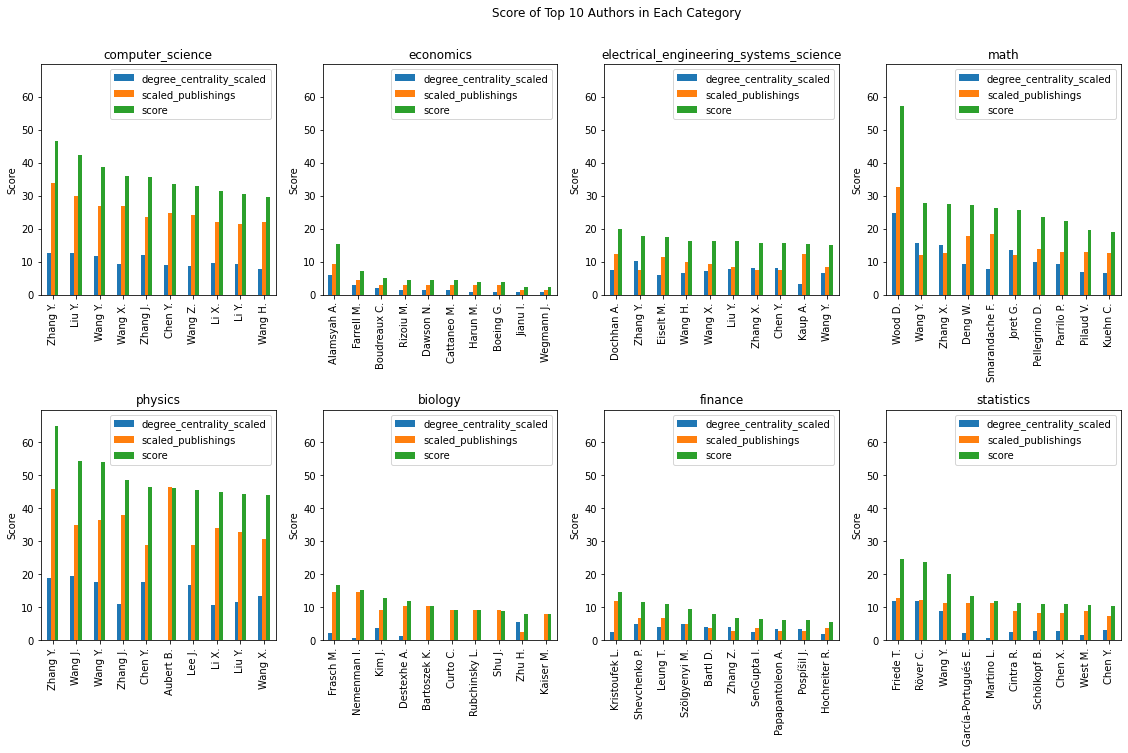

In [ ]:
# Plot the distribution of the top n scoring Authors
ncols = 4
nrows = math.ceil(len(all_categories) / ncols)
fig = plt.figure(figsize=(20, 10))
ymax = max([df_by_cat[cat]['score'].max() for cat in all_categories]) + 5 # upper limit of ylim in all plots

for i in range(len(all_categories)):
    cat = all_categories[i]
    ax = fig.add_subplot(nrows, ncols, i + 1)

    df_by_cat[cat][['author', 'degree_centrality_scaled', 'scaled_publishings', 'score']].plot(ax=ax, kind='bar', x='author', stacked=False)
    ax.set_ylabel('Score')
    ax.set_ylim([0, ymax])
    ax.set_title(cat)
    ax.xaxis.label.set_visible(False)

plt.suptitle(f'Score of Top {n} Authors in Each Category')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.85,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.5)
plt.show()

# NLP Modeling Based on NLP Category Classification

---

## Preprocessing:
### For our model we will be starting off with the preprocessed data we had for our centrality analysis. In our case, we do not need to consider any other features in the data except the cleaned_categories (renamed to categories), and the abstract. Based on what is written in the abstract, we will build a model that has the capacity to determine which category this abstract should fall under.

In [ ]:
arxiv_clean_df = arxiv_df.drop(columns = ['authors'])
arxiv_clean_df = arxiv_clean_df.rename(columns = {'authors_cleaned': 'authors'})
arxiv_clean_df = arxiv_clean_df.drop(columns = ['authors'])
target = arxiv_clean_df[['clean_categories']]
data = arxiv_clean_df.drop('categories', axis = 1)
data = data.drop('clean_categories', axis = 1)
data = data.drop('title', axis = 1)

### From here, our features will simply be the list of abstracts, and our targets will be the list of our categories, but encoded in order to pass these labels into a Neural Network.

##EDIT: We had realized using a confusion matrix that our dataset had a very large majority of 6 (Physics). This was making our model not learn anything but falsely gave us a very high test accuracy (94%). Therefore, we decided to over-sample every other class but the majority (6), to combat the class imbalance. Using this we were able to improve upon our model after testing 

In [ ]:
import numpy as np
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
data_map = data[['abstract']]
target_map = target['clean_categories']
le = preprocessing.LabelEncoder()
targets = le.fit_transform(target_map)
rus = RandomOverSampler(random_state= 42, sampling_strategy='not majority')
data_rus, target_rus = rus.fit_resample(data_map, targets)

In [ ]:
data_rus = np.array(data_rus['abstract'])

### As shown below, we have 8 unique categories an abstract can fall under, and therefore the encodings range from numbers [0,7].

In [ ]:
le.classes_

array(['biology', 'computer_science', 'economics',
       'electrical_engineering_systems_science', 'finance', 'math',
       'physics', 'statistics'], dtype=object)

### To create a dataset that combines both the features and targets into a format suitable for PyTorch datasets, we appended the features and targets into a list of tuples (a,b) where **a** is the category that the abstract **b** is assigned to:

In [ ]:
dataset = []
for i in range(len(data_rus)):
  dataset.append((target_rus[i], data_rus[i]))

## Model Implementation
### From here we begin creating our Neural Network. The general idea is to tokenize the key words in each abstract and use an embedding bag to create a vector representation of a set of words. Given that individual words have various meanings, we need to consider the context behind these words to effectively categorize. Therefore, an embedding bag allows us to represent those sets of words as a vector, to ensure that the context of a phrase or word is not lost.
### These embedding bag vectors would then be passed through a linear model to provide a prediction of the abstract's categories. When training, it will go through the abstract in batches, rather than all at once, allowing us to run this model without the need for GPU. 

In [ ]:
import torch
device = torch.device("cpu")

#### We define our text and label pipelines by first tokenizing our abstract data, then passing the tokenized text into our iterator that returns words that are classified as 'basic_english'. Any words that are not within what is defined as 'basic english' are replaced with the 'unknown' keyword

In [ ]:
import nltk
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.corpus import stopwords

nltk.download('stopwords')
tokenizer = get_tokenizer('basic_english')
train_iter = iter(dataset)
stop_words = set(stopwords.words("english"))

def yield_tokens(data_iter):
    for _, text in data_iter:
        tokens = tokenizer(text)
        new_tokens = []
        for t in tokens:
          if t in stop_words:
            continue
          else:
            new_tokens.append(t)
        yield new_tokens

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### The pipelines created above will later be used to create DataLoader for both the Training and Testing split. This dataloader will be processing the data in batches, which is where the function collate_batch comes into play. This function is meant to create a tensor based on the pipelines established above. A list of label tensors, text tensors, and offset tensors are created to predict and train with Cross Entropy Loss.

In [ ]:
from torch.utils.data import DataLoader

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


#### From here is where the actual Model is designed. The components of the model is an EmbeddingBag to create vectorized sets of text from the abstract, a linear model taking the embedded data and the features, and a function to initialize embedding and linear weights to a value between [-0.5, 0.5]. Forward Pass is simply the embedding of the abstract, with the linear model called right after on the embeddings.

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

#### To train our model, we have implemented a train function where for each set of label, text, and offsets, we get a predicted label based on our current model, and determine the loss based on Cross Entropy.
#### From there we use this loss to perform backwards propogation on our model to adjust the weights. During this process we also keep count of the total number of correct predictions to determine the accuracy of model for the number of batches done so far. This continues until all batches are trained on.
#### In this block we also create a function to evaluate the accuracy of a model without training the model as well. This will end up being useful when determining the accuracy of the testing data. Essentially the model predicts the categories of the test abstracts and counts the number of correct predictions out of the total predictions.

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

## Running our Model
### Finally, we begin to run our model with the dataset we had created earlier. We set up inital parameters such as the number of classes, the size of our vocabulary that we use, and the size of each embedding bag.
### Using these, we initialize our text classification model.

In [ ]:
train_iter = dataset
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 5
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

#### We'll be basing the loss on Cross Entropy, the optimizer on Stochastic Gradient Descent, and decaying our learning rate based on step_size with StepLR. 
#### We split our dataset using random split to get 80% for training and 20% for testing - then create our training and testing dataloaders.
#### Finally, we begin training. We train our model in batches, using the train function described above, then determine the test accuracy using the evaluate function. That testing accuracy will be appended to a list to see how the number of iterations through the training data affects the accuracy of the test. At the end of the Epoch, the test accuracy is returned.

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Accuracy History
test_acc_hist = []

# Hyperparameters
EPOCHS = 1 # epoch
LR = 5  # learning rate
BATCH_SIZE = 32 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter = dataset

train_dataset = to_map_style_dataset(train_iter)

num_train = int(len(train_dataset) * 0.80)
split_train_, split_test_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(split_test_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(test_dataloader)
    test_acc_hist.append(accu_val)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'test accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/23447 batches | accuracy    0.853
| epoch   1 |  1000/23447 batches | accuracy    0.862
| epoch   1 |  1500/23447 batches | accuracy    0.848
| epoch   1 |  2000/23447 batches | accuracy    0.859
| epoch   1 |  2500/23447 batches | accuracy    0.868
| epoch   1 |  3000/23447 batches | accuracy    0.866
| epoch   1 |  3500/23447 batches | accuracy    0.865
| epoch   1 |  4000/23447 batches | accuracy    0.850
| epoch   1 |  4500/23447 batches | accuracy    0.866
| epoch   1 |  5000/23447 batches | accuracy    0.859
| epoch   1 |  5500/23447 batches | accuracy    0.869
| epoch   1 |  6000/23447 batches | accuracy    0.870
| epoch   1 |  6500/23447 batches | accuracy    0.867
| epoch   1 |  7000/23447 batches | accuracy    0.870
| epoch   1 |  7500/23447 batches | accuracy    0.868
| epoch   1 |  8000/23447 batches | accuracy    0.876
| epoch   1 |  8500/23447 batches | accuracy    0.862
| epoch   1 |  9000/23447 batches | accuracy    0.881
| epoch   1 |  9500/23447 ba

## Visualization and Analysis
## This portion was before we fixed class imbalance:
### Using the test accuracy history and the number of epochs used, we can form of visual representation of the test accuracy as we perform multiple training iterations of the dataset. What we see is that from the beginning, the test accuracy was very high - the highest being 93.7%, and by the end of the 10th epoch, the highest we reached was 94.2%. This high of an accuracy could be due to not enought variation in our test data, and we may need a larger dataset to get a better representation of how well our model can do.

### What we do know, however, is that assuming the size of our dataset is reasonable for a Neural Network, we see that by embedding our abstract into sets of words, vectorized, and run through a logistic layer, we can provide an accurate category for an abstract.

## After fixing imbalance we were able to train our model using one epoch and get a test accuracy of approx. 87%. If we were to run on multiple epochs, we can expect a slight increase in testing accuracy.

## Therefore, we can assume that since we handled class imbalance, our model can provide an effective and accurate way to classify abstracts into a category. 

### Some assumptions we have in this model is that each abstract falls under only one category, when in reality it is quite likely for an abstract to fall under many categories. Trying to implement the idea of multiple categories with this model results in issues, as it would just consider an abstract with multiple labels as a completely separate classification. 

## Below is the code for before fixing class imbalance, we visualized our graph and visualized the confusion matrix to see that physics was a very large majority and the cause of the imbalance.

In [ ]:
# Visualization
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(range(1, EPOCHS + 1), test_acc_hist)
plt.xlabel("Num of Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy as Epochs Increase")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix as cm

In [ ]:
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
  for idx, (label, text, offsets) in enumerate(test_dataloader):
    predicted_label = model(text, offsets)
    y_pred.append([i.item() for i in list(predicted_label.argmax(1))])
    y_true.append([i.item() for i in list(label)])

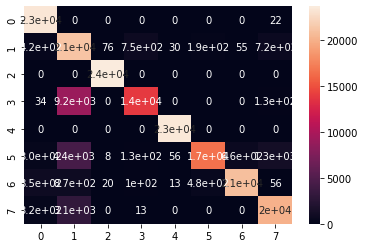

In [ ]:
yt = [i for sub in y_true for i in sub]
yp = [i for sub in y_pred for i in sub]
con_mat = cm(yt, yp)
sns.heatmap(con_mat, annot= True)